In [18]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from pyro import clear_param_store
import pyro.contrib.gp as gp
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive,HMC
import torch
import kennard_stone as ks
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook
from bokeh.layouts import column,gridplot
#from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
from scipy import stats
from sklearn.metrics import root_mean_squared_error

In [2]:
train=pd.read_excel(r"../data/chem_train.xlsx")


In [3]:
test=pd.read_excel(r"../data/chem_test.xlsx")


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
X_no2=torch.tensor(train.corrected_week.values).float().to(device)
y_no2=torch.tensor(train.no2.values).float().to(device)
X_no2_test=torch.tensor(test.corrected_week.values).float().to(device)
y_no2_test=torch.tensor(test.no2.values).float().to(device)

In [6]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

In [7]:
clear_param_store()
rbf = gp.kernels.RBF(input_dim=1)


rbf.variance = PyroSample(dist.HalfNormal(torch.tensor(10.)))

rbf.lengthscale = PyroSample(dist.HalfNormal(torch.tensor(10.)))

gpr = gp.models.GPRegression(X_no2,y_no2, rbf).to(device)
gpr.noise = PyroSample(dist.HalfNormal(torch.tensor(10.)))


nuts_kernel = NUTS(gpr.model)


mcmc = MCMC(nuts_kernel,warmup_steps=9000, num_samples=1000,num_chains=1)

mcmc.run()

Sample: 100%|██████████████████████████████████████| 10000/10000 [03:46, 44.20it/s, step size=7.09e-01, acc. prob=0.912]


In [8]:
torch.save(gpr, "../models/no2_seasonality");

In [9]:
posterior_samples = mcmc.get_samples(500)
posterior_predictive= Predictive(gpr, posterior_samples)(X_no2)
prior = Predictive(gpr, num_samples=500)(X_no2)

pyro_data = az.from_pyro(mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,

)
az.to_json(pyro_data, "../Arviz_stats/mcmc_no2_seasonality.json")

/data/michaelf/miniconda3/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


'../Arviz_stats/mcmc_no2_seasonality.json'

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

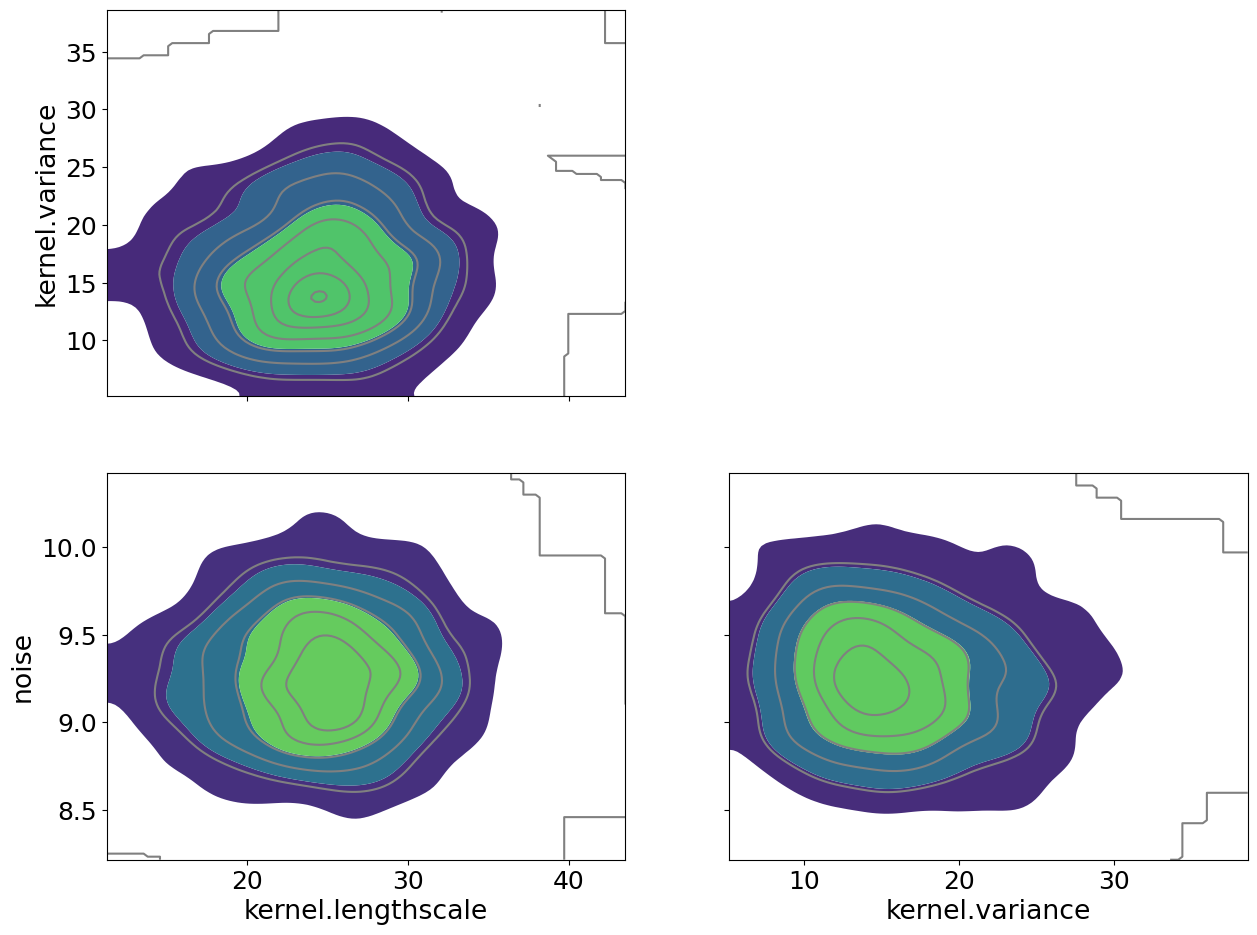

In [10]:
az.plot_pair(pyro_data,kind='kde',divergences=True,textsize=18)

In [11]:
X_nox=torch.tensor(train.corrected_week.values).float().to(device)
y_nox=torch.tensor(train.nox.values).float().to(device)
X_nox_test=torch.tensor(test.corrected_week.values).float().to(device)
y_nox_test=torch.tensor(test.nox.values).float().to(device)

In [12]:
clear_param_store()
rbf_bc = gp.kernels.RBF(input_dim=1)


rbf_bc.variance = PyroSample(dist.HalfNormal(torch.tensor(10.)))

rbf_bc.lengthscale = PyroSample(dist.HalfNormal(torch.tensor(10.)))

gpr_bc = gp.models.GPRegression(X_nox,y_nox, rbf_bc).to(device)
gpr_bc.noise = PyroSample(dist.HalfNormal(torch.tensor(10.)))


nuts_kernel_bc = NUTS(gpr_bc.model)


mcmc_bc = MCMC(nuts_kernel_bc,warmup_steps=9000, num_samples=1000,num_chains=1)

mcmc_bc.run()

Sample: 100%|██████████████████████████████████████| 10000/10000 [03:29, 47.81it/s, step size=8.22e-01, acc. prob=0.902]


In [13]:
torch.save(gpr_bc, "../models/nox_seasonality");

In [14]:
posterior_samples_bc = mcmc_bc.get_samples(500)
posterior_predictive_bc = Predictive(gpr_bc, posterior_samples_bc)(X_nox)
prior_bc = Predictive(gpr_bc, num_samples=500)(X_nox)

pyro_data_bc = az.from_pyro(mcmc_bc,
    prior=prior_bc,
    posterior_predictive=posterior_predictive_bc,

)
az.to_json(pyro_data_bc, "../Arviz_stats/mcmc_nox_seasonality.json")

'../Arviz_stats/mcmc_nox_seasonality.json'

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

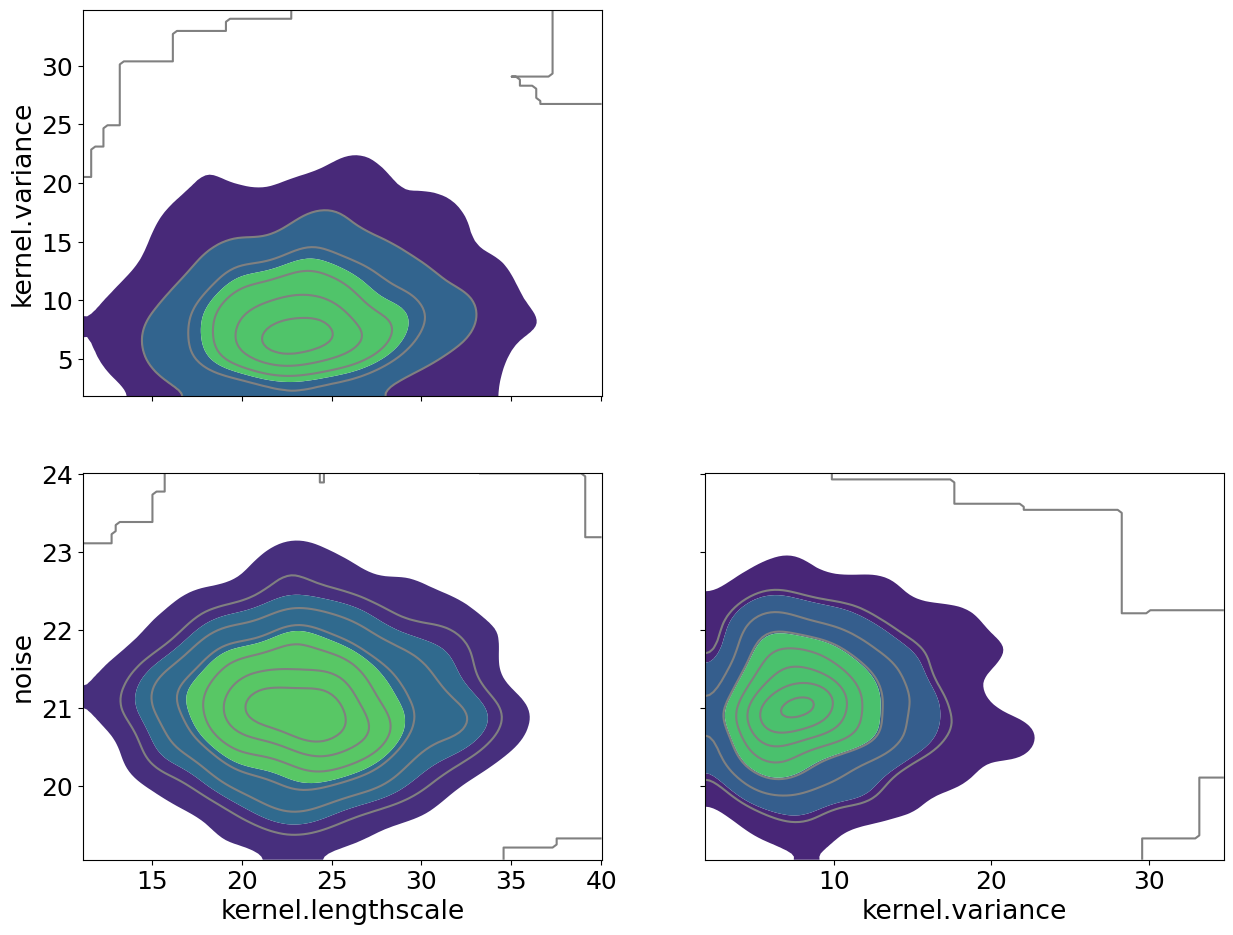

In [15]:
az.plot_pair(pyro_data_bc,kind='kde',divergences=True,textsize=18)

In [16]:
r2_score(y_nox_test.cpu().detach().numpy(),gpr_bc(X_nox_test)[0].cpu().detach().numpy())

-0.017842650413513184

In [17]:
r2_score(y_no2_test.cpu().detach().numpy(),gpr(X_no2_test)[0].cpu().detach().numpy())

-0.04575622081756592

In [19]:
root_mean_squared_error(y_nox_test.cpu().detach().numpy(),gpr_bc(X_nox_test)[0].cpu().detach().numpy())

3.207551956176758

In [20]:
root_mean_squared_error(y_no2_test.cpu().detach().numpy(),gpr(X_no2_test)[0].cpu().detach().numpy())

3.096749782562256